This notebook aims to reproduce figure 7.6 in Wakeley's "Coalescent Theory: an Introduction". In order to do so, we will first load the function we need for calculating the rate matrix of the coalescent process:

In [1]:
from IPython.display import SVG
import numpy as np
import pandas as pd
%load_ext rpy2.ipython

In [2]:
def recombination(i):
    """
    This function returns all possible states after a 
    single recombination event given an initial state
    """
    # Create empty list
    new_lst = []
    # For each block index in the list
    for block in range(len(i)):
        # If the site is linked
        if 0 not in i[block]:
            # Remove block
            lst = i[:block]+i[block+1:]
            # Split block
            lst = lst + [(i[block][0], 0), (0, i[block][1])]
            # Append to list
            new_lst.append(sorted(lst))
    return new_lst

In [3]:
def coalescent(i):
    """
    This function returns all possible states after a 
    single coalescence event given an initial state. 
    The returned list is somewhat ordered, so that the 
    first states correspond to reversible coalescence 
    events, and the last to non-reversible ones.
    """
    # Get unique values per site
    n_0 = set([0]+list(sum(i, ())))
    reversible = []
    nonreversible = []
    # For each combination of blocks
    for b1 in range(len(i)):
        for b2 in range(b1+1, len(i)):
            # Create new block by merging
            add_lst = [(i[b1][0]+i[b2][0], i[b1][1]+i[b2][1])]
            # For each index in i
            for b3 in range(len(i)):
                # If the index is not in among the merged blocks
                if b3 not in [b1, b2]:
                    # Append to list
                    add_lst.append(i[b3])
            # If the unique values are different from the 
            # original block
            if set([0]+list(sum(add_lst, ()))) == n_0:
                # Append to reversible coalescence list
                reversible.append(sorted(add_lst))
            else:
                # Append to non-reversible coalescence list
                nonreversible.append(sorted(add_lst))
    l = reversible+nonreversible
    return l

In [4]:
def idx(i):
    j = list(sum(i, ()))
    return -(len(j)-j.count(0))

def get_states(lst):
    """
    Given a list of states, this function finds all possible
    recombination and coalescence states iteratively.
    """
    # Sort block per states just in case
    all_states = [sorted(i) for i in lst]
    # Define pool of states to be transformed
    state_pool = all_states
    # While the pool is non-empty
    while len(state_pool) > 0:
        # Define result list per iteration
        iter_states = []
        # For each of the states in the pool
        for i in state_pool:
            # Save coalescent transformation
            iter_states = iter_states+coalescent(i)
            # Save recombination transformation
            iter_states = iter_states+recombination(i)
        # Keep unique values in the original order
        iter_states = sorted(list(list(i) for i in set(tuple(row) for row in iter_states)), key = iter_states.index)
        # Define pool for next round
        state_pool = [i for i in iter_states if i not in all_states]
        # Add pool to overall list
        all_states += state_pool
        
    all_states = sorted(all_states, key = idx)
    return all_states

Starting in the situation where we have three genomes, each with two linked loci, we can obtain the full list of possible states:

In [5]:
state_2 = [[(1, 1), (2, 2), (4, 4)]]
iter_lst_2 = get_states(state_2)
iter_lst_2[0:10]

[[(1, 1), (2, 2), (4, 4)],
 [(0, 1), (1, 0), (2, 2), (4, 4)],
 [(0, 2), (1, 1), (2, 0), (4, 4)],
 [(0, 4), (1, 1), (2, 2), (4, 0)],
 [(0, 1), (0, 2), (1, 0), (2, 0), (4, 4)],
 [(0, 1), (0, 4), (1, 0), (2, 2), (4, 0)],
 [(0, 2), (0, 4), (1, 1), (2, 0), (4, 0)],
 [(0, 2), (1, 0), (2, 1), (4, 4)],
 [(0, 1), (1, 2), (2, 0), (4, 4)],
 [(0, 1), (0, 2), (0, 4), (1, 0), (2, 0), (4, 0)]]

We can also calculate a list of simplified states, where we do not care about keeping track of the different alleles.

In [6]:
# Define a dictionary to simplify the tuples
# 1 represents an uncoalesced site
# 2 and 3 represent a coalesced site from 
# 2 or 3 sites, respectively
dct_simple = {
    0:0,
    1:1,
    2:1,
    3:2,
    4:1,
    5:2, 
    6:2,
    7:3
}

# Change original list to simplified notation
lst_2 = [sorted([(dct_simple[j[0]], dct_simple[j[1]]) for j in i]) for i in iter_lst_2]
# Get reduced list in original order
lst_simple_2 = sorted([list(i) for i in list(set([tuple(t) for t in lst_2]))], key = lst_2.index)

# Convert lists to parse into R
lst_2_str = [str(i) for i in lst_2]
iter_lst_2_str = [str(i) for i in iter_lst_2]
lst_simple_2_str = [str(i) for i in lst_simple_2]

len(lst_simple_2)

31

We can now calculate the transition rate matrix between the states, where `C` would correspond to the coalescence rate and `R` to the recombination rate:

In [7]:
def get_trans_mat(iter_lst_2, tht, rho):
    trans_mat_2 = np.full((len(iter_lst_2), len(iter_lst_2)), '0')
    for i in range(len(iter_lst_2)):
        new_lst = recombination(iter_lst_2[i])
        idx_lst = [iter_lst_2.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat_2[i,j]=rho
        new_lst = coalescent(iter_lst_2[i])
        idx_lst = [iter_lst_2.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat_2[i,j]=tht
        
    return pd.DataFrame(trans_mat_2)

In [8]:
trans_mat = get_trans_mat(iter_lst_2, 'C', 'R')
trans_mat

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,202
0,0,R,R,R,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C,0,0,0,R,R,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C,0,0,0,R,0,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C,0,0,0,0,R,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,C,C,0,0,0,0,C,C,R,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C
199,0,0,0,0,0,0,0,0,0,0,...,C,0,0,0,0,0,0,0,0,C
200,0,0,0,0,0,0,0,0,0,0,...,0,C,0,0,0,0,0,0,0,C
201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,R


In [9]:
df = pd.DataFrame(trans_mat)
new_df = (df.rename_axis(index = 'from')
            .reset_index()
            .melt('from', var_name='to')
            .reindex(columns = ['value','from','to']))
tab_mat_2 = new_df[new_df['value'] != '0']
tab_mat_2.head()

,value,from,to
1,C,1,0
2,C,2,0
3,C,3,0
203,R,0,1
207,C,4,1


In order to convert the original matrix, we can divide the total number of transitions with the number of unique non-simplified states per simplified state.

In [ ]:
%%R -i lst_2_str -i lst_simple_2_str -i tab_mat_2 -o mat_2_simple

library(tidyverse)

mat_2_simple <- as_tibble(tab_mat_2) %>%
    # Add simplified state information
    mutate(    
        from_str = unlist(lst_2_str)[from+1],
        to_str = unlist(lst_2_str)[to+1]
    )  %>%
    # Group by transitions between simplified states
    group_by(from_str, to_str) %>%
    summarize(
        # Either R or C
        val = unique(value),
        # Number of non-simplified transitions / number of non-simplified states
        x = n()/(length(unique(from)))
    )  %>%
    # Get new transition probability
    unite('value', c(x, val), sep = '') %>%
    # Get new indices of states
    mutate(
        from = match(from_str,unlist(lst_simple_2_str))-1,
        to = match(to_str,unlist(lst_simple_2_str))-1
    ) %>% 
    ungroup() %>%
    select(value, from, to)  %>%
    arrange(from) %>%
    pivot_wider(values_from = value, names_from = to, values_fill = '0', names_sort = TRUE) %>%
    as.matrix()
    
mat_2_simple <- mat_2_simple[,-1]
rownames(mat_2_simple) <- colnames(mat_2_simple)
mat_2_simple <- as.data.frame(mat_2_simple)
mat_2_simple[1:10, 1:10]

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



`summarise()` has grouped output by 'from_str'. You can override using the `.groups` argument.
   0  1  2  3  4  5  6  7  8  9
0  0 3R  0  0  0  0  0  0  0  0
1 1C  0 2R  0 2C 2C  0  0  0  0
2  0 4C  0 1R  0  0 1C 2C 1C 2C
3  0  0 9C  0  0  0  0  0  0  0
4  0  0  0  0  0  0 1R 1R  0  0
5  0  0  0  0  0  0  0  0 1R 1R
6  0  0  0  0 2C  0  0  0  0  0
7  0  0  0  0 2C  0  0  0  0  0
8  0  0  0  0  0 2C  0  0  0  0
9  0  0  0  0  0 2C  0  0  0  0


In [ ]:
mat_2_simple

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,3R,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1C,0,2R,0,2C,2C,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,4C,0,1R,0,0,1C,2C,1C,2C,...,0,0,0,0,0,0,0,0,0,0
3,0,0,9C,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1R,1R,0,0,...,0,0,0,0,1C,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1R,1R,...,0,0,0,0,0,1C,0,0,0,0
6,0,0,0,0,2C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,2C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,2C,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,2C,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can now think about how to obtain the variance of the number of segregating sites ($\text{Var}[S]$) given $\theta$ and $\rho$. Following Hudson and Kaplan (1985), the variance of S in an infinite sites model can be calculated using the covariance of the total branch length $T_{total}$ for two loci, which in turn depends on $\rho$. Hudson and Kaplan (1985) developed a method to compute Cov[$T_{total, 1}, T_{total, 2}$] for two loci and an arbitrary sample size using a recursive system of equations (equation 4). Pluzhnikov and Donnelly (1996) simplified the recursion (equation A7), although the result is identical. After having computed Cov[$T_{\text{total}, 1}, T_{\text{total}, 2}$], it can be plugged in Hudson and Kaplan (1985) equation 8 to compute $\text{Var}[S]$.

The system of recursive functions, although general, it is difficult to implement. Luckily, we can apply phase-type theory to get the same result. We know that the number of segregating sites for each locus will depend on the genealogy that the sequences follow. As a result, we can generate a multivariate continuous phase-type distribution with two rewards, representing the time total branch length ($T_{\text{total}}$) for the left site and the right site ($T_{\text{1}}$ and $T_{\text{2}}$ in Wakeley's book, respectively). The rewards will be either 0, 2 or 3 for each state, representing whether that site has already coalesced (0) and will not contribute to S, whether there are two genealogies left, or whether all 3 genealogies are still present. 

In [ ]:
def get_reward_mat(iter_lst_2):
    
    # Create empty matrix
    trans_mat_2 = np.full((len(iter_lst_2), 2), 0.0)
    
    # For each state
    for i in range(len(iter_lst_2)):
        
        # Set accumulator
        acc = 0
        # For each genome
        for j in iter_lst_2[i]:
            # If the left allele exists
            if j[0] in [1, 2]:
                # Add 1 to accumulator
                acc += 1
        # Add a reward of 1 if there are 2 alleles
        trans_mat_2[i, 0] = acc
        
        acc = 0
        # For each genome
        for j in iter_lst_2[i]:
            # If the left allele exists
            if j[1] in [1, 2]:
                # Add 1 to accumulator
                acc += 1
        # Add a reward of 1 if there are 2 alleles
        trans_mat_2[i, 1] = acc
        
    return trans_mat_2

In [ ]:
reward_mat = get_reward_mat(lst_simple_2)
reward_mat

array([[3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 2.],
       [2., 3.],
       [3., 2.],
       [3., 2.],
       [2., 3.],
       [2., 3.],
       [3., 2.],
       [2., 3.],
       [2., 2.],
       [2., 2.],
       [2., 2.],
       [2., 2.],
       [2., 2.],
       [2., 2.],
       [2., 2.],
       [3., 0.],
       [0., 3.],
       [3., 0.],
       [0., 3.],
       [2., 0.],
       [0., 2.],
       [2., 0.],
       [0., 2.],
       [2., 0.],
       [0., 2.],
       [0., 0.],
       [0., 0.]])

Additionally, we can translate the generic transition rate matrix to one with the proper coalescent rate and recombination rate:

In [ ]:
%%R -i reward_mat 

fun_trans <- function(x, coa, rho) {
    if (str_detect(x, 'R')) {
        return(as.integer(str_sub(x, 1, 1))*rho)
    } else if (str_detect(x, 'C')) {
        return(as.integer(str_sub(x, 1, 1))*coa)
    } else return(0)
}

set_coa_rho <- function(X, coa, rho) {
    
    X = data.frame(lapply(X, Vectorize(fun_trans), coa = coa, rho = rho))
    X = as.matrix(X)
    X <- matrix(as.numeric(X),    # Convert to numeric matrix
                  ncol = ncol(X))
    X[row(X)==col(X)] = -rowSums(X)
    X                                    
}

set_coa_rho(mat_2_simple, 1, 1)[1:10, 1:10]


      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]   -6    3    0    0    0    0    0    0    0     0
 [2,]    1   -8    2    0    2    2    0    0    0     0
 [3,]    0    4  -11    1    0    0    1    2    1     2
 [4,]    0    0    9  -15    0    0    0    0    0     0
 [5,]    0    0    0    0   -5    0    1    1    0     0
 [6,]    0    0    0    0    0   -5    0    0    1     1
 [7,]    0    0    0    0    2    0   -7    0    0     0
 [8,]    0    0    0    0    2    0    0   -7    0     0
 [9,]    0    0    0    0    0    2    0    0   -7     0
[10,]    0    0    0    0    0    2    0    0    0    -7


We now have all the ingredients to get a multivariate continuous phase-type distribution. We should remember that phase-type distributions are defined by their sub-intensity matrix, that lacks the absorbing state. Thus, we will need to remove the last two states from our rate matrix and the reward matrix, and then we can use `PhaseTypeR` to create a MPH distribution and calculate its covariance $\text{Cov}[T_i, T_j]$

In [ ]:
%%R 

library(PhaseTypeR)
library(tidyverse)

R[write to console]: Loading required package: expm

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘expm’


R[write to console]: The following object is masked from ‘package:Matrix’:

    expm


R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


R[write to console]: The following objects are masked from ‘package:purrr’:

    compose, simplify


R[write to console]: The following object is masked from ‘package:tidyr’:

    crossing


R[write to console]: The following object is masked from ‘package:tibble’:

    as_data_frame


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, s

In [ ]:
%%R

coa = 1

Ttotal <- function(x) {
    rho = x/2
    mph <- MPH(
        set_coa_rho(mat_2_simple, coa, rho)[1:(nrow(mat_2_simple)-2),1:(nrow(mat_2_simple)-2)],
        c(1, rep(0, nrow(mat_2_simple)-3)), 
        reward_mat[1:(nrow(mat_2_simple)-2),]
    )
    mph
}

covar_Ttotal <- function(x) {
    var(Ttotal(x))[1, 2]
}

var_Ttotal <- function(x) {
    diag(var(Ttotal(x)))
}

mean_Ttotal <- function(x) {
    mean(Ttotal(x))
}


Additionally, we can transform the reward to get a phase-type representation of $T_{\text{MRCA}}$ for two loci. In this case, the reward will be only 1 or 0:

In [ ]:
%%R

Tmrca <- function(x) {
    rho = x/2
    mph <- MPH(
        set_coa_rho(mat_2_simple, coa, rho)[1:(nrow(mat_2_simple)-2),1:(nrow(mat_2_simple)-2)],
        c(1, rep(0, nrow(mat_2_simple)-3)), 
        ifelse(reward_mat[1:(nrow(mat_2_simple)-2),] != 0, 1, 0)
    )
    mph
}

covar_Tmrca <- function(x) {
    var(Tmrca(x))[1, 2]
}

var_Tmrca <- function(x) {
    diag(var(Tmrca(x)))
}

mean_Tmrca <- function(x) {
    mean(Tmrca(x))
}

In [ ]:
%%R 

print(covar_Ttotal(0))  
print(var_Ttotal(0))    # Eq. 3.25
print(mean_Ttotal(0))   # Eq. 3.23
print(covar_Tmrca(0))
print(var_Tmrca(0))     # Eq. 3.26
print(mean_Tmrca(0))    # Eq. 3.24

[1] 5
[1] 5 5
[1] 3 3
[1] 1.111111
[1] 1.111111 1.111111
[1] 1.333333 1.333333


We can now build a graph over a grid of rho values:

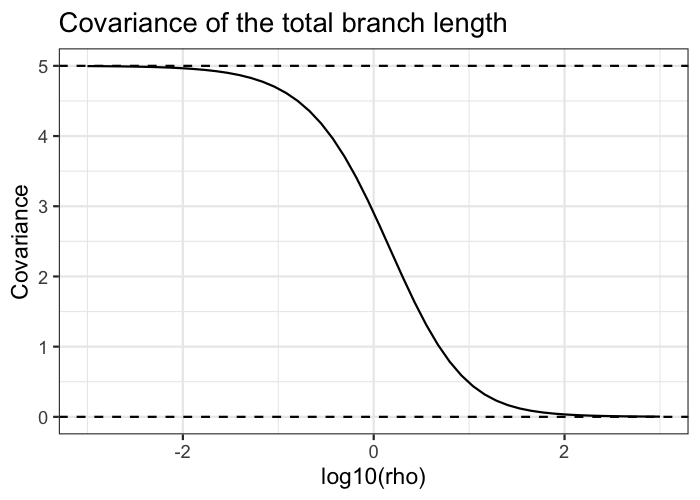

In [ ]:
%%R  -w 700 -h 500 -r 150

# Create a logarithmic sequence
lseq <- function(from, to, length.out) {
  exp(seq(log(from), log(to), length.out = length.out))
}

covar_Ttotal_error <- function(x) {
    tryCatch(covar_Ttotal(x), error=function(e) NA)
}

rho_lst = lseq(0.001, 1000, length.out = 50)
phasetype_covar <- unlist(lapply(rho_lst, covar_Ttotal_error))

covar_tib <- tibble(
    rho = rho_lst,
    covar = phasetype_covar,
) 

covar_tib %>%
    ggplot() +
    geom_line(aes(log10(rho), covar)) +
    geom_hline(aes(yintercept = y), 
               linetype = 2,
               data = tibble(y = c(0, 5))) +
    theme_bw() +
    ylab('Covariance') +
    ggtitle('Covariance of the total branch length')

From Pluzhnikov and Donnelly (1996), we can use their recursion A7 to calculate $\text{Cov}[T_{\text{total,1}\text{, }\text{total,2}}]$ for a sample size of n:

In [ ]:
%%R 

n <- function(a, b, c) a+b+c
bn <- function(a, b, c, z) (n(a,b,c)*(n(a,b,c)-1)+c*z)/2
r1 <- function(c, z) c*z/2
r2 <- function(a, b) a*b
r3 <- function(a, b, c) a*c+a*(a-1)/2
r4 <- function(a, b, c) b*c+b*(b-1)/2
r5 <- function(c) c*(c-1)/2
Rn <- function(a, b, c) 2*c*(c-1)/((a+c-1)*(b+c-1))

print_F <- function(a, b, c, z) {
  tmp_name <- c()
  tmp_value <- c()
  
  bn_tmp <- bn(a, b, c, z)
  
  if (any(c(a, b, c)<0) | any(c(a+c, b+c)<2)) {
    tmp <- tibble(iter = paste0('F(',a,b,c,')'),
         tmp_name,
         tmp_value)
    return(tmp)
  }
  
  
  if (all(c(a+1, b+1, c-1)>=0) & all(c(a+1+c-1, b+1+c-1)>=2)) {
    tmp_name <- c(tmp_name, paste0('F(',a+1,b+1,c-1,')'))
    tmp_value <- c(tmp_value, r1(c,z))
  }
  
  if (all(c(a-1, b-1, c+1)>=0) & all(c(a-1+c+1, b-1+c+1)>=2)) {
    tmp_name <- c(tmp_name, paste0('F(',a-1,b-1,c+1,')'))
    tmp_value <- c(tmp_value, r2(a,b))
  }
  
  if (all(c(a-1, b, c)>=0) & all(c(a-1+c, b+c)>=2)) {
    tmp_name <- c(tmp_name, paste0('F(',a-1,b,c,')'))
    tmp_value <- c(tmp_value, r3(a,b,c))
  }
  
  if (all(c(a, b-1, c)>=0) & all(c(a+c, b-1+c)>=2)) {
    tmp_name <- c(tmp_name, paste0('F(',a,b-1,c,')'))
    tmp_value <- c(tmp_value, r4(a,b,c))
  }
  
  if (all(c(a, b, c-1)>=0) & all(c(a+c-1, b+c-1)>=2)) {
    tmp_name <- c(tmp_name, paste0('F(',a,b,c-1,')'))
    tmp_value <- c(tmp_value, r5(c))
  }
  
  tmp_name <- c(tmp_name, 'Rn')
  tmp_value <- c(tmp_value, Rn(a,b,c))/bn_tmp
  
  tmp_name <- c(tmp_name, paste0('F(',a,b,c,')'))
  tmp_value <- c(tmp_value, -1)
  
  tibble(iter = paste0('F(',a,b,c,')'),
         tmp_name,
         tmp_value)
}

In [ ]:
%%R 


get_recursion_var <- function(rho) {
    tib <- bind_rows(
      print_F(0, 0, 3, rho),
      print_F(1, 1, 2, rho),
      print_F(0, 0, 2, rho),
      print_F(2, 2, 1, rho),
      print_F(0, 1, 2, rho),
      print_F(1, 0, 2, rho),
      print_F(1, 1, 1, rho),
      print_F(3, 3, 0, rho),
      print_F(1, 2, 1, rho),
      print_F(2, 1, 1, rho),
      print_F(2, 2, 0, rho),
      print_F(2, 3, 0, rho),
      print_F(3, 2, 0, rho),
    ) %>% 
      pivot_wider(
        names_from = tmp_name,
        values_from = tmp_value, 
        values_fill = 0) %>% 
      select(-iter) %>% 
      select(Rn, starts_with('F'))


    left <- as.matrix(tib[-1])
    right <- -as.matrix(tib[1])

    solve(left, right)['F(003)',]
}

print(get_recursion_var(1))
print(covar_Ttotal(1))


[1] 2.90625
[1] 2.90625


We see that the result is the same:

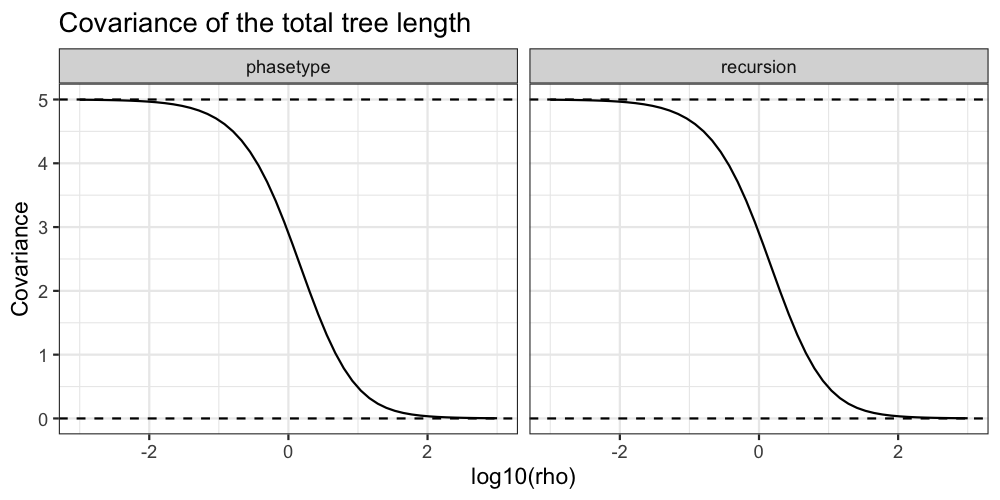

In [ ]:
%%R -w 1000 -h 500 -r 150

recursion_covar <- unlist(lapply(rho_lst, get_recursion_var))

covar_tib_2 <- tibble(
    rho = rho_lst,
    phasetype = phasetype_covar,
    recursion = recursion_covar
)

covar_tib_2 %>%
    pivot_longer(-rho)  %>%
    ggplot() +
    geom_line(aes(log10(rho), value)) +
    geom_hline(aes(yintercept = y), 
               linetype = 2,
               data = tibble(y = c(0, 5))) +
    theme_bw() +
    facet_wrap(~name) +
    ylab('Covariance') +
    ggtitle('Covariance of the total tree length')

We can see that when rho is very large, the covariance approaches 0, meaning that recombination would completely unlink the two loci. On the other hand, when rho is very small, then the loci will remain linked and will have the same genealogy.

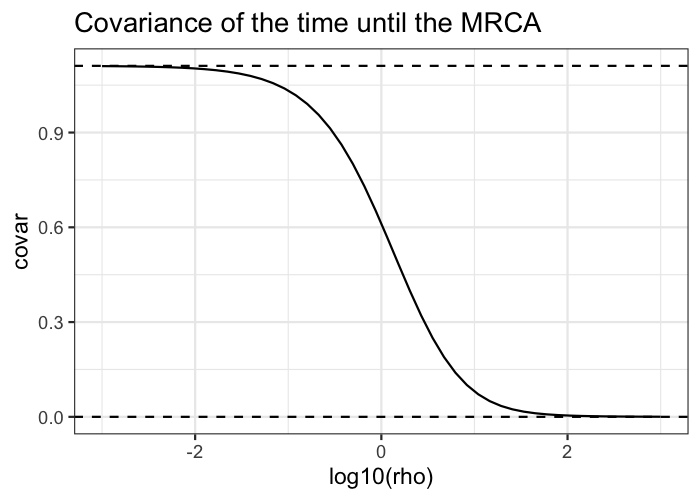

In [ ]:
%%R  -w 700 -h 500 -r 150

# Create a logarithmic sequence
lseq <- function(from, to, length.out) {
  exp(seq(log(from), log(to), length.out = length.out))
}

covar_Tmrca_error <- function(x) {
    tryCatch(covar_Tmrca(x), error=function(e) NA)
}

rho_lst = lseq(0.001, 1000, length.out = 50)
phasetype_covar <- unlist(lapply(rho_lst, covar_Tmrca_error))

covar_tib <- tibble(
    rho = rho_lst,
    covar = phasetype_covar) 

covar_tib %>%
    ggplot() +
    geom_line(aes(log10(rho), covar)) +
    geom_hline(aes(yintercept = y), 
               linetype = 2,
               data = tibble(y = c(0, 10/9))) +
    theme_bw() +
    ggtitle('Covariance of the time until the MRCA')

We can see that when rho is very large, the covariance approaches 0, meaning that recombination would completely unlink the two loci. On the other hand, when rho is very small, then the loci will remain linked and will have the same genealogy.

If we want to reproduce figure 7.6, we first need to calculate the integral specified in equation 7.20. This equation is defined in terms of $T_{\text{MRCA}}$ (i.e. $f_2(x)$ corresponds to $\text{Cov}[T_1^{\text{MRCA}}, T_2^{\text{MRCA}}]$. However, equation 7.20 is only true for $n=2$. The reason for this is that $\text{Var}(S)$ can only be defined in terms of $T_{tot}$ for a general case:

$$
\text{Var}[S] = \sum_{i=1}^m\text{Var}[S_i]+2\sum_{i=1}^{m-1}\sum_{j=i+1}^{m}\text{Cov}[S_i, S_j]
$$

\begin{align}
    \text{Cov}[S_1, S_2]& = \text{E}[S_1S_2]-\text{E}[S_1]\text{E}[S_2] \\
    & = \text{E}[\text{E}[S_1S_2|T_1^{tot},T_2^{tot}]]-\text{E}\left[\text{E}[S_1|T_1^{tot}]\right]\text{E}\left[\text{E}[S_2|T_2^{tot}]\right] \\
    & = \text{E}\left[\text{E}[S_1|T_1^{tot}]\text{E}[S_2|T_2^{tot}]\right]-\text{E}\left[\text{E}[S_1|T_1^{tot}]\right]\text{E}\left[\text{E}[S_2|T_2^{tot}]\right] \\
    & = \text{E}\left[\frac{\theta_1}{2}T_1^{tot}\frac{\theta_2}{2}T_2^{tot}\right]-\text{E}\left[\frac{\theta_1}{2}T_1^{tot}\right]\text{E}\left[\frac{\theta_2}{2}T_2^{tot}\right] \\
    & = \frac{\theta_1\theta_2}{4}\left(E[T_1^{tot}T_2^{tot}]-E[T_1^{tot}]E[T_2^{tot}]\right) \\
    & = \frac{\theta_1\theta_2}{4}\text{Cov}[T_1^{tot},T_2^{tot}]
\end{align} 

For $n=2$, because $T_{tot}=2T_{\text{MRCA}}$, then $\text{Cov}[T_1^{tot},T_2^{tot}]=4\text{Cov}[T_1^{\text{MRCA}},T_2^{\text{MRCA}}]$. Therefore, $\text{Cov}[S_1, S_2]=\frac{\theta_1\theta_2}{4}\text{Cov}[T_1^{tot},T_2^{tot}]=\theta_1\theta_2\text{Cov}[T_1^{\text{MRCA}},T_2^{\text{MRCA}}]$. This is why equation 7.20 can be defined in terms of $T_\text{MRCA}$, but this only holds true for $n=2$.

Instead, it is more convenient to re-formulate equation 7.20 in terms of $T_{tot}$ for a more general case:

$$
\text{Var}(S) = \theta\sum_{i=1}^{n-1}\frac{1}{i}+\frac{\theta^2}{2\rho^2}\int_{\rho}^{0} (\rho-x)\,\text{Cov}[T_1^{tot}, T_2^{tot}\,|\,x] \,dx
$$

This equation should be the same as equation 8 in Hudson and Kaplan. However, I suspect that there is a misprint in the publication, since $\text{Var}(T(\infty))$ should be divided by 4.

In [27]:
%%R

## CAREFUL! 
## Note that fn(x) in equation 8 in Hudson and Kaplan
## corresponds to the covariance of the total tree
## length divided by 4. Coincidentally, this covariance
## equals the covariance of Tmrca for n=2, but it does 
## not work for n>2.

# This function is what need to be integrated
covar_Tmrca_error_2 <- function(x, rho) {
    (rho-x)*covar_Ttotal(x)/4
}

# This performs the integral
integrate_covar <- function(rho) {
    integrate(Vectorize(covar_Tmrca_error_2), lower = 0, upper = rho, rho = rho)$value
}

# This returns Var_S or NA if there is an error
vec_fun_var <- function(rho) {
    tryCatch(tht*(1+1/2)+(2*tht^2/(rho^2))*integrate_covar(rho), error=function(e) NA)
}


tht = 1
print(vec_fun_var(1e-10))
print(tht*(3/2)+tht^2*(5/4))

print(vec_fun_var(100000))
print(tht*(3/2))


rho_lst = lseq(0.001, 100000, length.out = 40)
var_lst = unlist(lapply(rho_lst, vec_fun_var))
var_tib = tibble(rho_lst = rho_lst, var_lst = var_lst)

[1] 2.75
[1] 2.75
[1] 1.500207
[1] 1.5


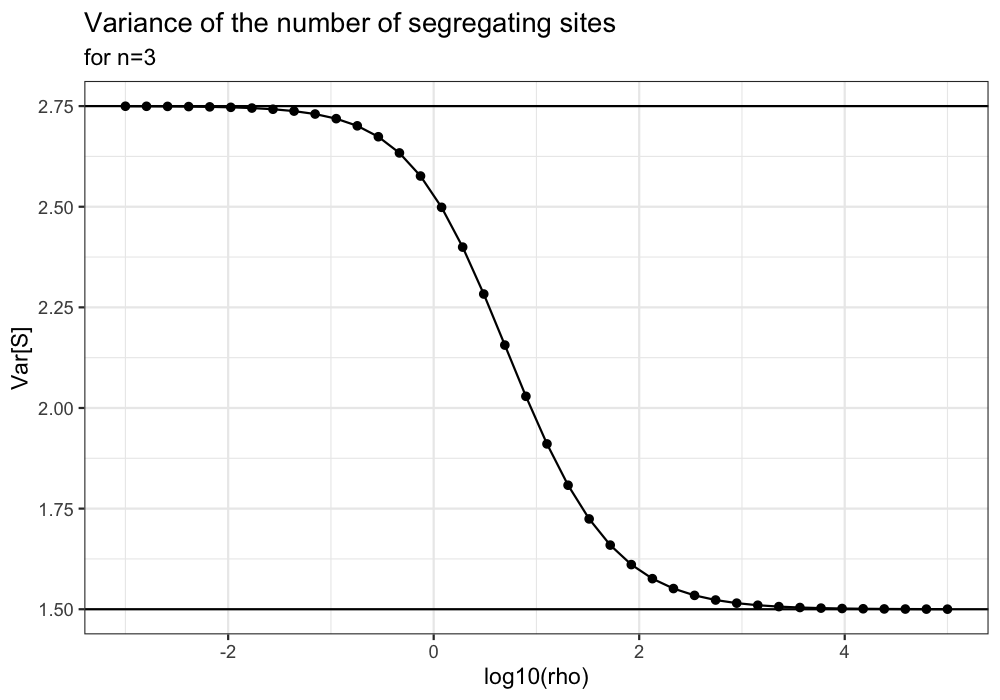

In [28]:
%%R -w 1000 -h 700 -r 150

var_tib %>% 
    drop_na() %>% 
    ggplot() +
    geom_point(aes(log10(rho_lst), var_lst)) +
    geom_line(aes(log10(rho_lst), var_lst)) +
    geom_hline(aes(yintercept = y), data = tibble(y = c(tht*(3/2)+tht^2*(5/4), tht*(3/2)))) +
    theme_bw() +
    ylab('Var[S]') +
    xlab('log10(rho)') +
    ggtitle('Variance of the number of segregating sites', 'for n=3')

We can observe that in the case of no recombination, the variance of S equals Watterson's result (equation 4.8 in Wakeley). On the other hand, in the case of free recombination, the variance of S approaches $1.5*\theta$, which equals the expectation of S assuming that it follows a Poisson distribution (equation 7.12 or 7.14 in Wakeley, remember that in Poisson Var = E). 